In [21]:
# Notebook vorbereiten
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil 
ab_ag_raw = pd.read_csv('../data/ab_ag.tsv', sep='\t')
columns = pd.read_csv('../data/columns.tsv', sep='\t')
uniprot_data = pd.read_csv('../data/uniprot_data.tsv', sep='\t')

# ab_ag aus ab_ag_raw aufbereiten
ab_ag = ab_ag_raw[["pdb", "Hchain", "Lchain", "model", "antigen_chain", "antigen_name", "antigen_species","resolution"]].copy()
# Füge Spalten für die CDR-Sequenzen in ab_ag hinzu
for col in ["CDR_H1", "CDR_H2", "CDR_H3", "CDR_L1", "CDR_L2", "CDR_L3"]:
    if col not in ab_ag.columns:
        ab_ag[col] = np.nan
    ab_ag[col] = ab_ag[col].astype(object)
# Entferne Einträge ohne Antigennamen
ab_ag.dropna(subset=["antigen_chain"], inplace=True)

# Zeilen entfernen, bei denen resolution <= 3.5
ab_ag = ab_ag[ab_ag['resolution'] <= 3.5]

In [22]:
#Kopie des annotated datensatzes erstellen
ab_ag_annotated_copy = pd.read_csv('../data/ab_ag_annotated.tsv', sep='\t')
#anzahl der einträge vor der Löschung zur Kontrolle
count_beforedeletion = len(ab_ag_annotated_copy)
#löschung der einträge mit identischer sequenz
ab_ag_uniquesequences = ab_ag_annotated_copy.drop_duplicates(subset=['pdb', 'CDR_H1','CDR_H2','CDR_H3', 'CDR_L1', 'CDR_L2', 'CDR_L3'] )
#anzahl der einträge nach der löschung zur Kontrolle
duplicates_removed = count_beforedeletion - len(ab_ag_uniquesequences)
#mit f" können variablen in strings eingebaut werden
print(f"Anzahl gelöschter Einträge beträgt: {duplicates_removed}")

Anzahl gelöschter Einträge beträgt: 2494


C:\Users\avdh3\AppData\Local\Temp\ipykernel_7864\3511400665.py:78: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  legend_fig.tight_layout()


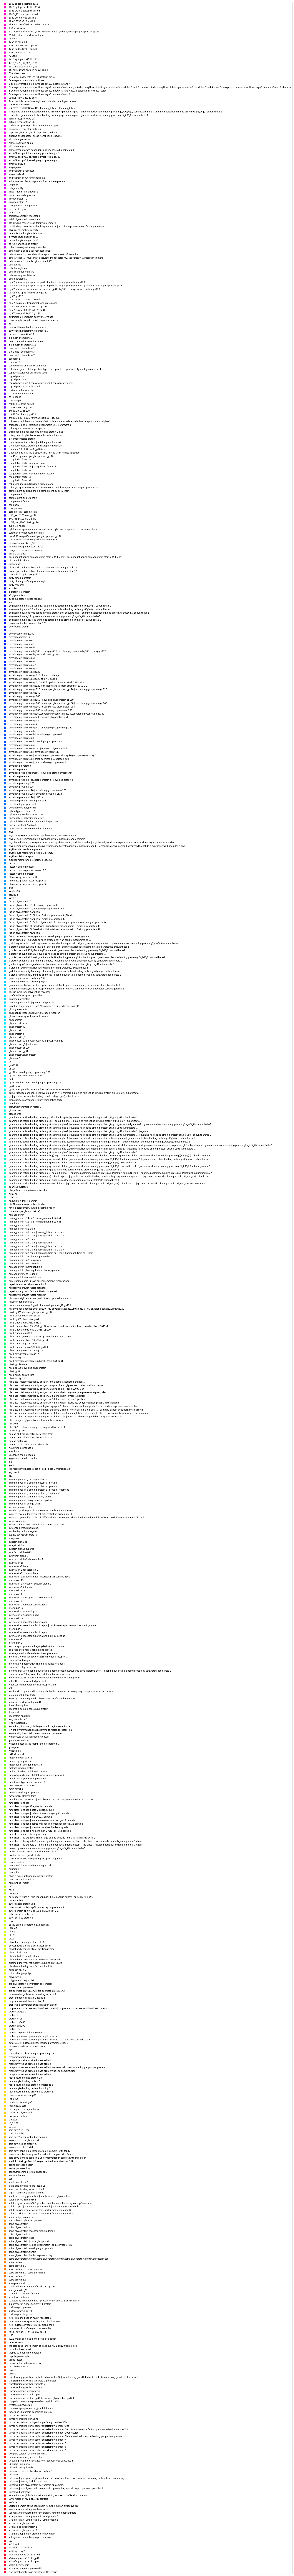

spike protein s1 | spike protein s1: (1.0, 0.4750604262799387, 0.0, 1.0)
plasmodium falciparum recombinant shortened csp: (0.8730681901413606, 1.0, 0.0, 1.0)
ig epsilon chain c region: (0.0, 1.0, 0.1879534924381503, 1.0)
10e8-gt4 epitope scaffold: (1.0, 0.0, 0.7794568163072935, 1.0)
lysozyme: (0.42627993847506024, 1.0, 0.0, 1.0)
glycoprotein: (0.0, 0.9003475904324258, 1.0, 1.0)
cobalt/magnesium transport protein cora: (0.2337398373983739, 0.0, 1.0, 1.0)
e protein | e protein: (0.005449511016849207, 0.0, 1.0, 1.0)
leucine-rich repeat and immunoglobulin-like domain-containing nogo receptor-interacting protein 1 : (0.30908957738226017, 1.0, 0.0, 1.0)
ch848.10.17 gp120: (0.3883881230116649, 0.0, 1.0, 1.0)
5'-nucleotidase, ecto (cd73), isoform cra_a: (1.0, 0.0, 0.9046482856132908, 1.0)
envelopment polyprotein: (0.0, 0.4511311417462, 1.0, 1.0)
guanine nucleotide-binding protein g(t) subunit alpha-3 | guanine nucleotide-binding protein g(i)/g(s)/g(o) subunitgamma-2  | guanine nucleotide-bindi

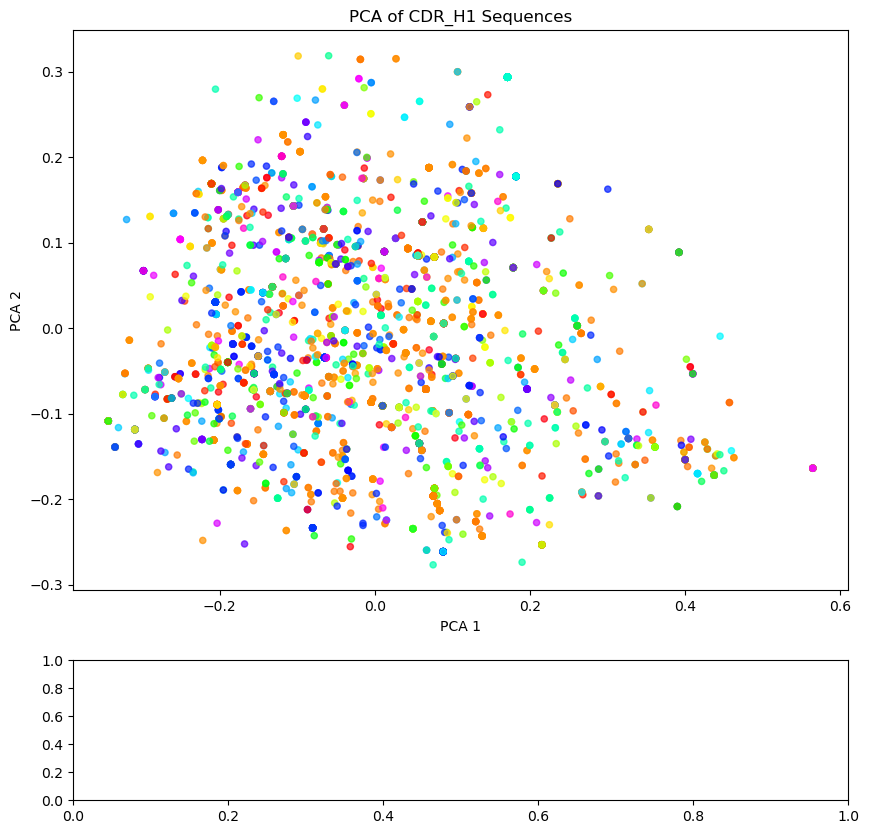

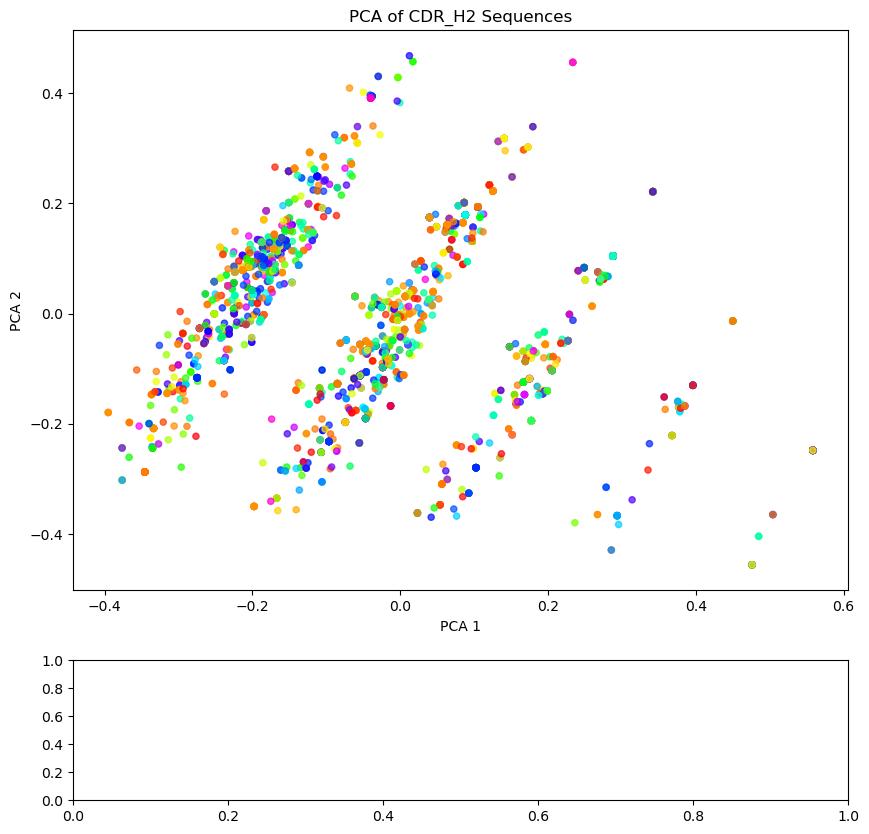

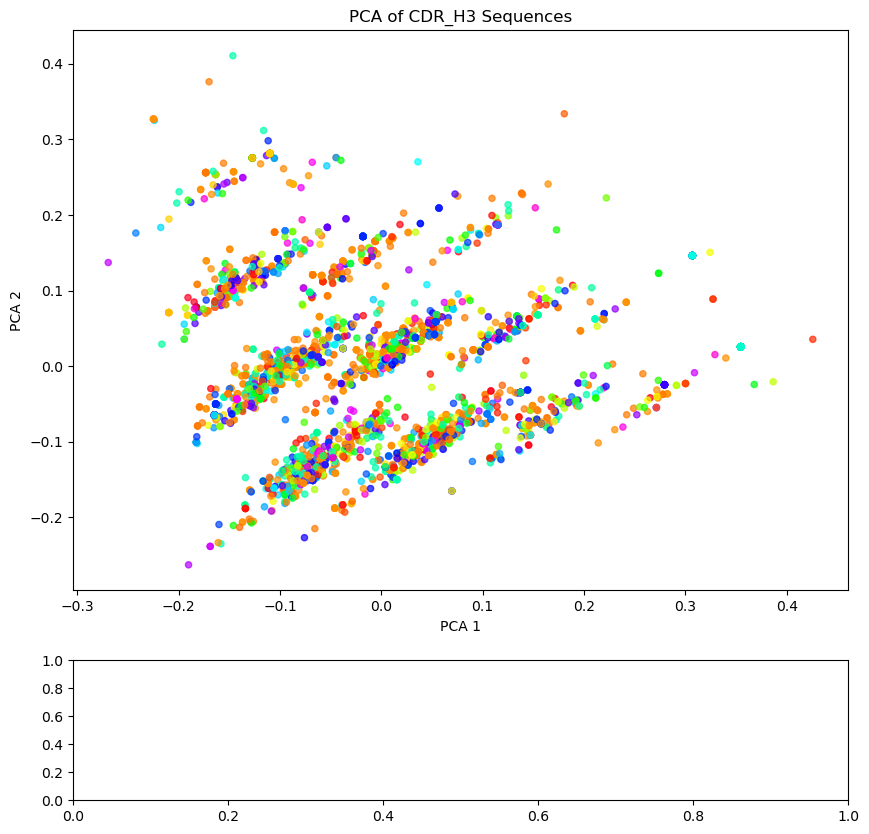

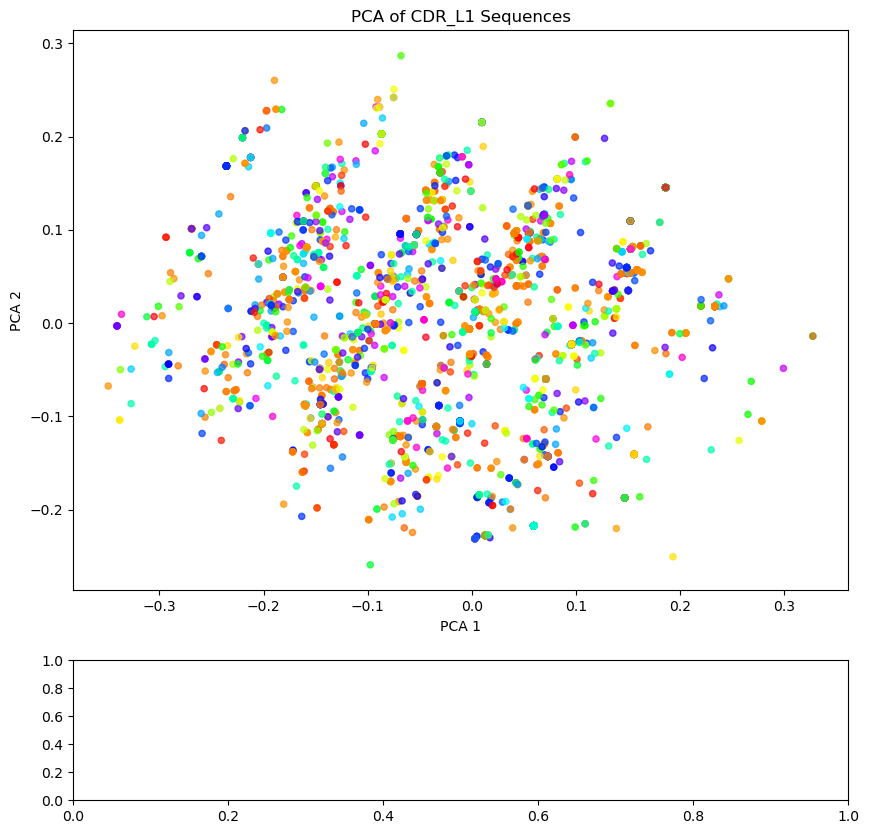

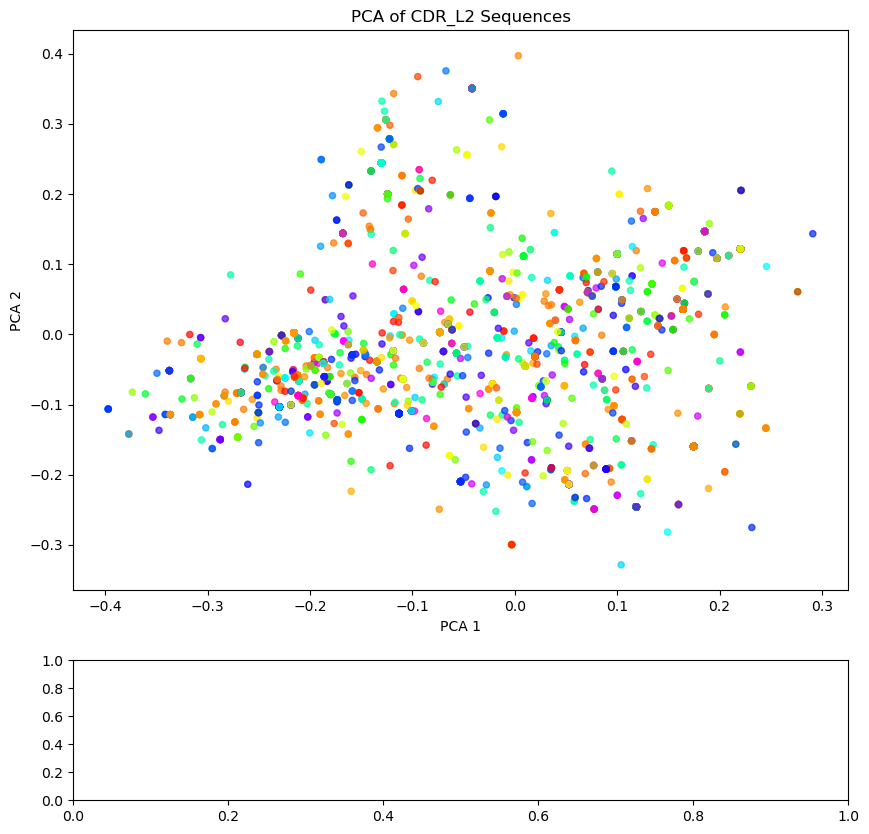

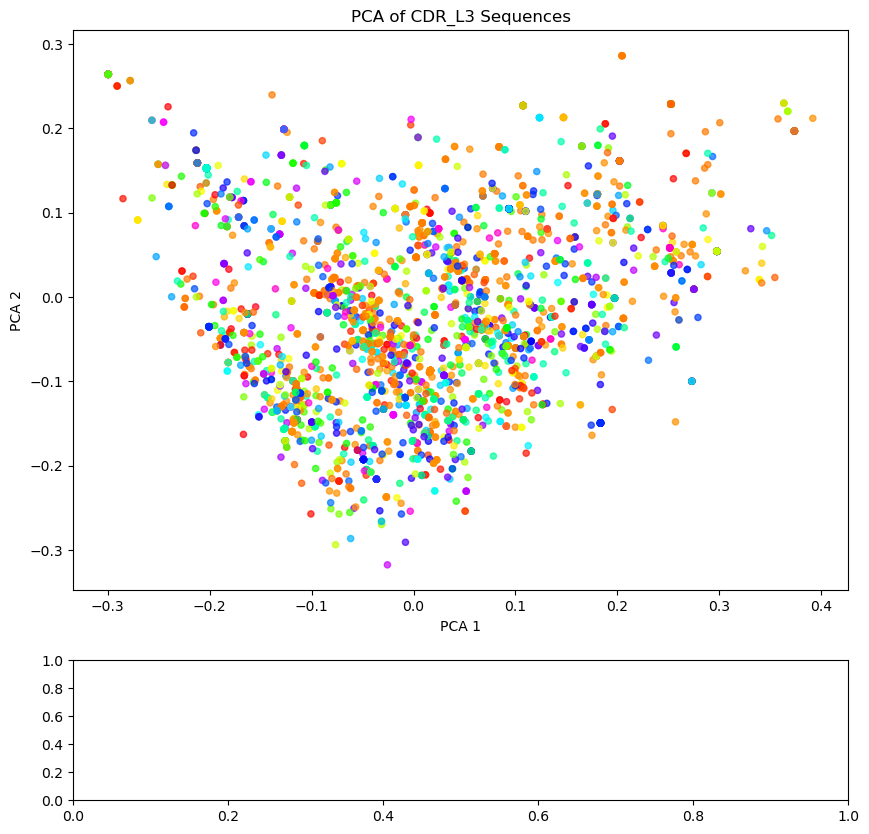

In [ ]:
# Zeilen für Color-Coding und Legende wurden nur reinkopiert und sind noch fehlerhaft! Nacharbeiten und verstehen!
# Problem hier: viel zu viele verschiedende antigen names => sehr unübersichtlich und außerdem hat benutzte farb pallete zu wenig farben

import ast
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def residue_percentage(sequence, residues):
    """
    Berechnet den prozentualen Anteil jeder Aminosäure in der gegebenen Sequenz und gibt eine Liste seq_residues zurück,
    die jede Aminosäure als Tupel (residue, percentage) enthält.
    sequence: list, die eine CDR-Sequenz repäsentiert, und deren Einträge aus einem String pro Aminosäure besteht, z.B. ['A', 'R', 'N', ...]
    residues: list, die alle proteinogenen Aminosäuren genau einmal als String enthält
    """
    seq_residues = []
    for residue in residues:
        percentage = sequence.count(residue) / len(sequence)
        seq_residues.append((residue, percentage))
    return seq_residues

ab_ag_annotated = pd.read_csv('../data/ab_ag_annotated.tsv', sep='\t')
ab_ag_annotated.drop_duplicates(subset=['pdb','CDR_H1','CDR_H2','CDR_H3', 'CDR_L1', 'CDR_L2', 'CDR_L3'], inplace=True) #Entferne identische Antikörper-Sequenzen mit gleichen PDB-IDs und CDR-Sequenzen
ab_ag_annotated.dropna(subset=['CDR_H1', 'CDR_H2', 'CDR_H3', 'CDR_L1', 'CDR_L2', 'CDR_L3'], inplace=True) #Entferne Einträge ohne CDR-Sequenzen


#####liste mit den antigen_names erstellen
antigen_labels = ab_ag_annotated["antigen_name"].tolist()

def show_feature_space(feature_space, CDR_region, antigen_labels):#zusätzliches Argument für color-coding: antigen
    """
    Visualisiert den Feature-Space der CDR-Sequenzen mittels PCA in 3D.
    feature_space: pd.DataFrame, der die PDB-IDs in einer Spalte "pdb" und die prozentualen Anteile der Aminosäuren in den entsprechenden CDR-Sequenzen
    in je einer Spalte pro Aminosäure enthält.
    """
    X = feature_space.drop(columns=["pdb"])
    coords = PCA(n_components=2).fit_transform(X)
    
    #### Farbzuordnung vorbereiten
    import matplotlib.lines as mlines

    unique_antigens = sorted(list(set(antigen_labels)))
    color_map = plt.get_cmap('gist_rainbow_r', len(unique_antigens))
    #color_dict = {antigen: color_map(i/len(unique_antigens)) for i, antigen in enumerate(unique_antigens)}
    color_dict = {antigen: color_map(i) for i, antigen in enumerate(unique_antigens)}
    colors = [color_dict[a] for a in antigen_labels]
   

    # Plotten der PCA-Koordinaten in 3D
    #fig = plt.figure(figsize=(15, 13))
    #ax = fig.add_subplot(111, projection='2d')
    fig, (ax_scatter, ax_legend) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={'height_ratios': [4,1]})
    ax_scatter.scatter(coords[:, 0], coords[:, 1], c=colors, s=20, alpha=0.7)#zusätzliche Argumente für color-coding: c=color_codes, cmap='tab20', 
    ax_scatter.set_xlabel("PCA 1")
    ax_scatter.set_ylabel("PCA 2")
    ax_scatter.set_title(f"PCA of {CDR_region} Sequences")


    #### Legende als extra plot 
    #handles = [plt.Line2D([], [], color=color_dict[ant], marker='o', linestyle= 'None', markersize=6 , label=ant,)
     #          for ant in unique_antigens]
    #ax_legend.axis('off')
    #legend = ax_legend.legend(handles=handles, loc='center', ncol=5, fontsize='small',)
    #ax.legend(handles=handles, title="Antigen", bbox_to_anchor=(1.05, 1), loc='upper left')
    #plt.tight_layout()
    #plt.show()

    # 2. Legende als eigene Figure
legend_fig, legend_ax = plt.subplots(figsize=(12, 12))  # Größe anpassen je nach Anzahl Antigene
legend_ax.axis('off')  # Keine Achsen

# Erstelle Handles
handles = [mlines.Line2D([], [], color=color_dict[ant], marker='o', linestyle='None',
                         markersize=8, label=ant)
           for ant in unique_antigens]

# Erzeuge Legende
legend = legend_ax.legend(handles=handles, loc='center', ncol=1, fontsize='small')  # ncol=1 → alle untereinander

legend_fig.tight_layout()
plt.show()

# Bereite ab_ag_annotated vor
ab_ag_annotated = pd.read_csv('../data/ab_ag_annotated.tsv', sep='\t')
ab_ag_annotated.drop_duplicates(subset=['pdb','CDR_H1','CDR_H2','CDR_H3', 'CDR_L1', 'CDR_L2', 'CDR_L3'], inplace=True) #Entferne identische Antikörper-Sequenzen mit gleichen PDB-IDs und CDR-Sequenzen
ab_ag_annotated.dropna(subset=['CDR_H1', 'CDR_H2', 'CDR_H3', 'CDR_L1', 'CDR_L2', 'CDR_L3'], inplace=True) #Entferne Einträge ohne CDR-Sequenzen

####sonst kann man nicht drauf zugreifen
import matplotlib.lines as mlines

unique_antigens = sorted(list(set(antigen_labels)))
color_map = plt.get_cmap('gist_rainbow_r', len(unique_antigens))
color_dict = {antigen: color_map(i) for i, antigen in enumerate(unique_antigens)}
colors = [color_dict[a] for a in antigen_labels]

# Schleife über die CDR-Regionen, um den Feature-Space für jede CDR-Sequenz zu erstellen und zu visualisieren:
for CDR_region in ["CDR_H1", "CDR_H2", "CDR_H3", "CDR_L1", "CDR_L2", "CDR_L3"]:
    # pd.dataframe mit den PDB-IDs und CDR-Sequenzen erstellen. Einträge sind keine Listen, sondern Strings, die Listen repräsentieren (aufgrund der .to_csv()-Methode)!
    sequences = ab_ag_annotated[["pdb", CDR_region]].copy()
    # CDR-Sequenzen im pd.dataframe sequences von Strings in Listen umwandeln. Die .items() greift auf die Index-Eintrag-Paare des pd.dataframes sequences zu.
    for i, s in sequences[CDR_region].items(): #i= Index, s = String, l= Liste
        l = ast.literal_eval(s)
        sequences.at[i, CDR_region] = l
    
    # Liste aller einzigartigen, proteinogenen Aminosäuren erstelllen, die in den CDR-Sequenzen vorkommen. Wird als Argument für residue_percentage benötigt.
    sequences_list = sequences[CDR_region].tolist()
    residues = sorted(np.unique(np.concatenate(sequences_list)))

    # Leere Matrix für den Feature-Space vorbereiten. Enthält die PDB-IDs, aber noch keine prozentualen Anteile der Aminosäuren.
    feature_space = pd.DataFrame(columns=residues, index=sequences.index)
    feature_space.insert(0, "pdb", ab_ag_annotated["pdb"])
    
    # Berechne den prozentualen Anteil jeder Aminosäure in den CDR-Sequenzen und füge sie in den Feature-Space ein.
    rows = [] #um daten vor befüllen des dataframes vorzubereiten damit es nicht so lange dauert
    for i in feature_space.index:
        sequence = sequences.at[i, CDR_region]
        seq_residues = residue_percentage(sequence, residues)
        row = {'pdb': sequences.at[i,'pdb']} #auch für schneller
        for residue, percentage in seq_residues: # Für jedes Tupel (Residue, prozentualer Anteil) in der Liste seq_residues
            feature_space.at[i, residue] = percentage # Füge den prozentualen Anteil des Residues in der CDR-Sequenz in die entsprechende Spalte ein
        rows.append(row)
    show_feature_space(feature_space, CDR_region, antigen_labels)

    #hat das mit den antigen names wirklich geklappt? das sind ja nicht alles antigen namen?


#Überprüfung ob alle punkte mit gleichem antigen-name die gleiche farbe haben am bsp influenza a virus
idx_influenzaavirus = [i for i, a in enumerate(antigen_labels) if a == "influenza a virus"]
set([colors[i] for i in idx_influenzaavirus])

#alle fraben pro antigen tabellarisch
for ant in set(antigen_labels):
    print(f"{ant}: {color_dict[ant]}")
    
  


Top 10 Antigene:
-spike glycoprotein
-spike protein s1
-guanine nucleotide-binding protein g(i) subunit alpha-1 | guanine nucleotide-binding protein g(i)/g(s)/g(t) subunitbeta-1 
-hemagglutinin
-envelope glycoprotein gp160
-envelope glycoprotein gp120
-surface glycoprotein
-neuraminidase
-hemagglutinin | hemagglutinin
-fusion glycoprotein f0


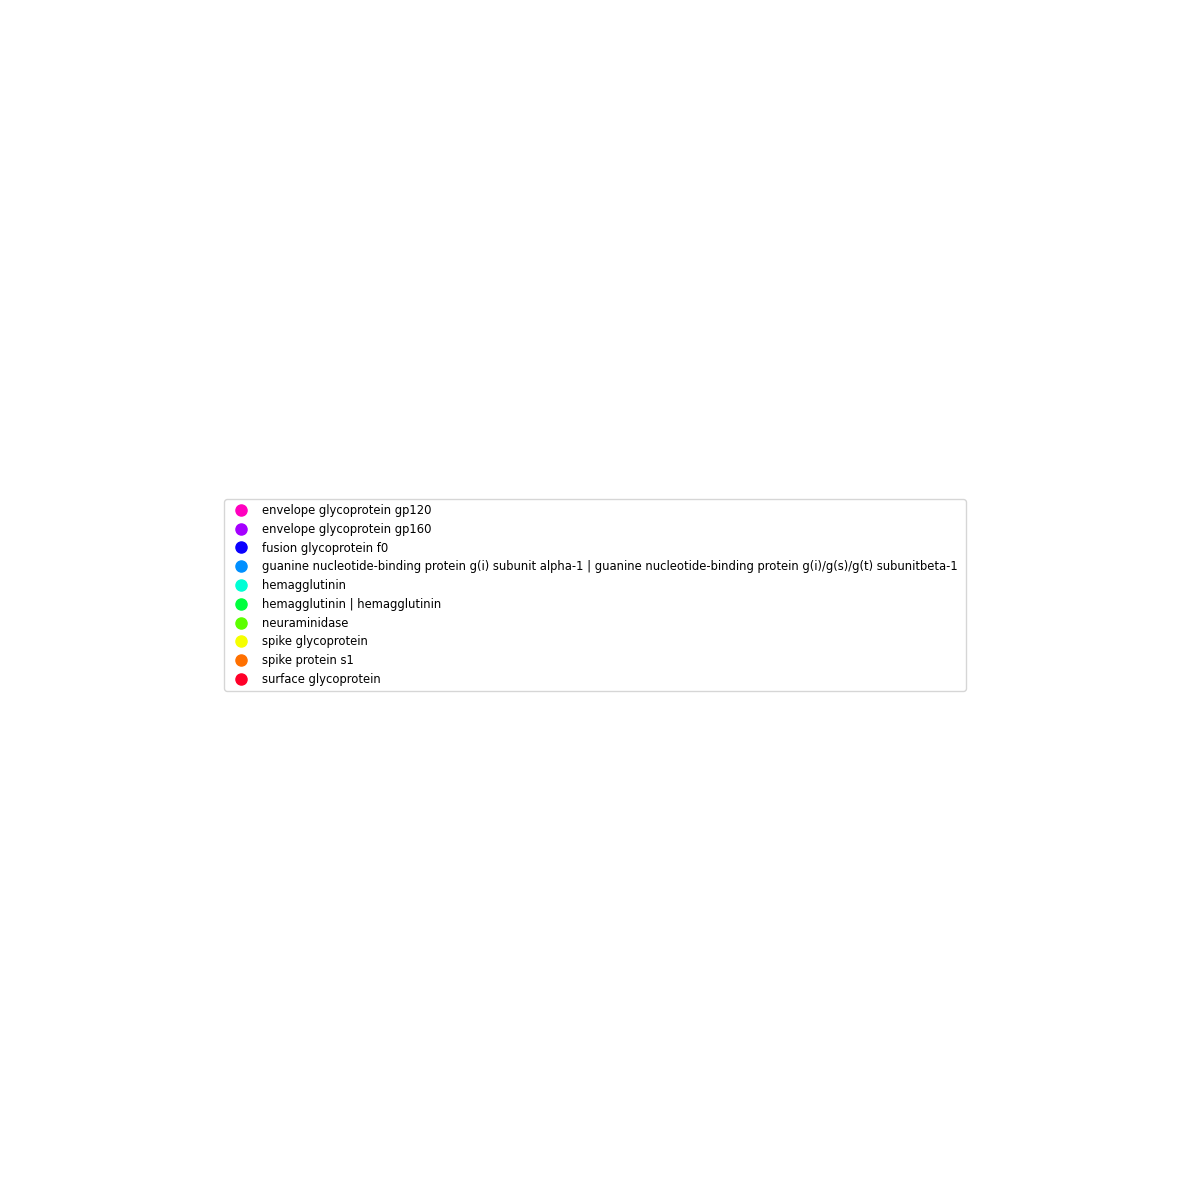

spike glycoprotein: (0.9609609609609602, 1.0, 0.0, 1.0)
guanine nucleotide-binding protein g(i) subunit alpha-1 | guanine nucleotide-binding protein g(i)/g(s)/g(t) subunitbeta-1 : (0.0, 0.5615942028985507, 1.0, 1.0)
hemagglutinin | hemagglutinin: (0.0, 1.0, 0.23894862604540001, 1.0)
fusion glycoprotein f0: (0.04227053140096615, 0.0, 1.0, 1.0)
neuraminidase: (0.36036036036036045, 1.0, 0.0, 1.0)
envelope glycoprotein gp160: (0.6461352657004832, 0.0, 1.0, 1.0)
surface glycoprotein: (1.0, 0.0, 0.16, 1.0)
spike protein s1: (1.0, 0.43843843843843866, 0.0, 1.0)
envelope glycoprotein gp120: (1.0, 0.0, 0.75, 1.0)
hemagglutinin: (0.0, 1.0, 0.836320191158901, 1.0)


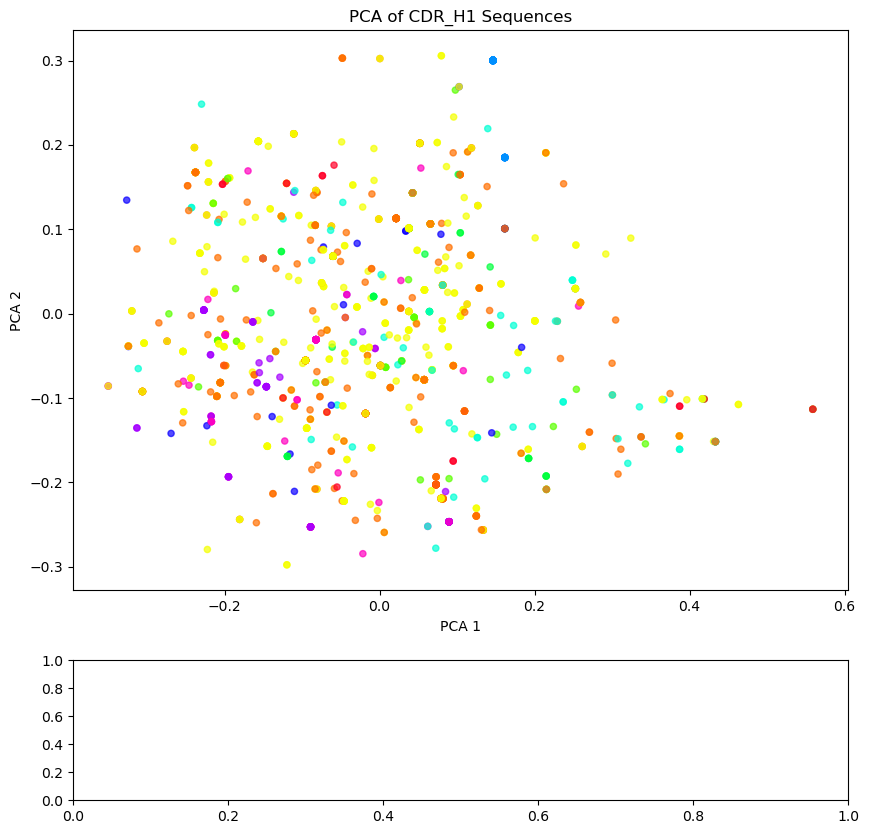

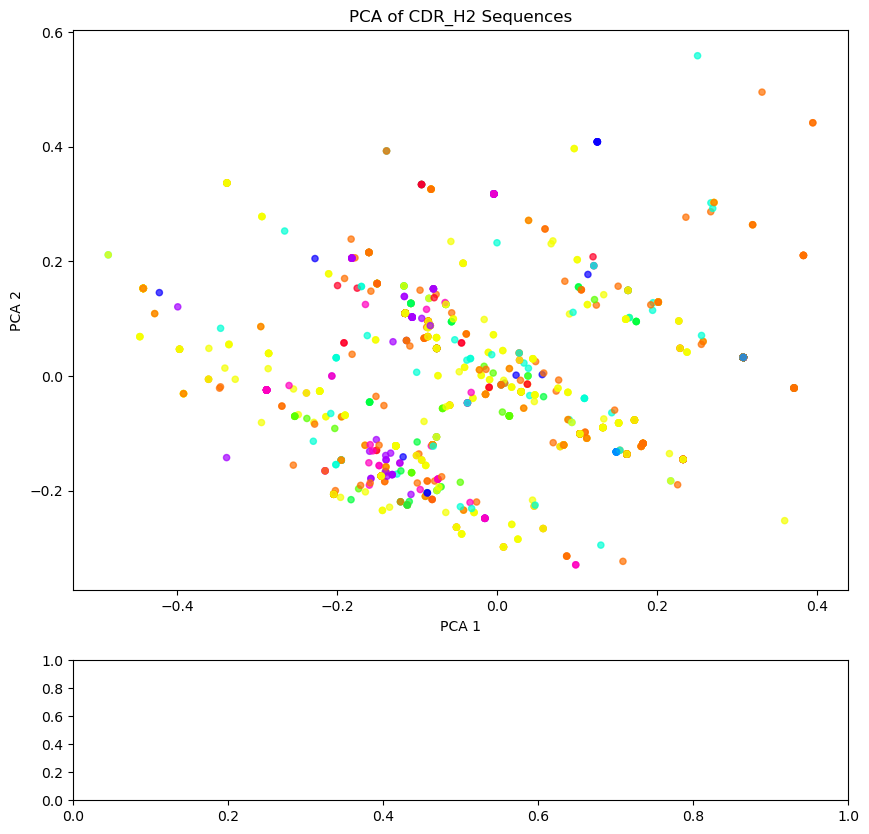

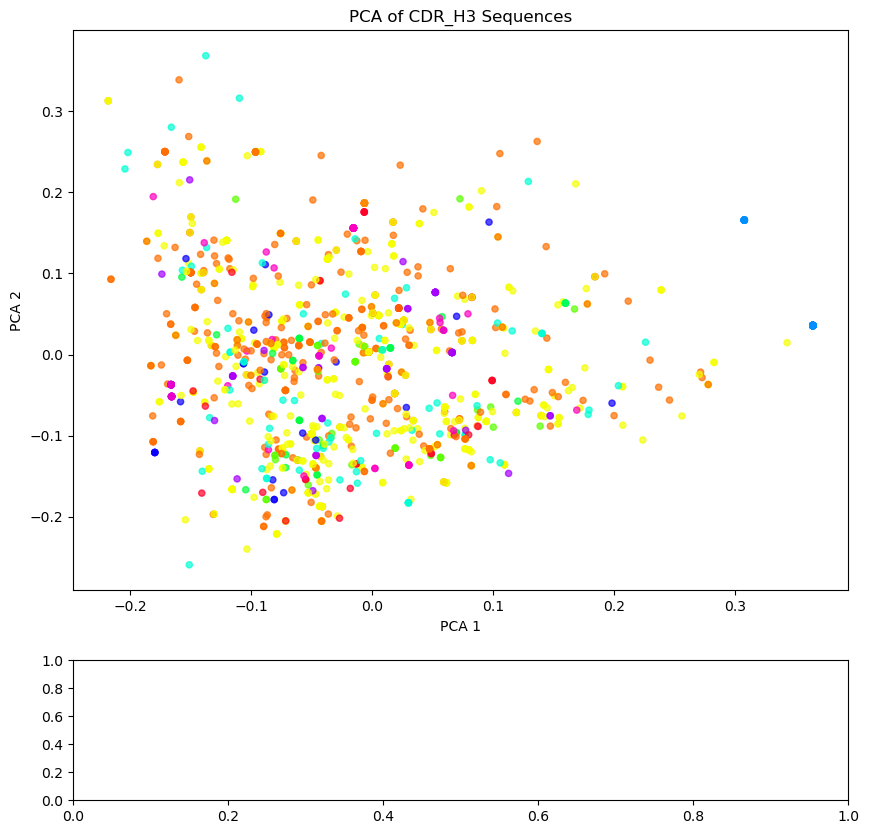

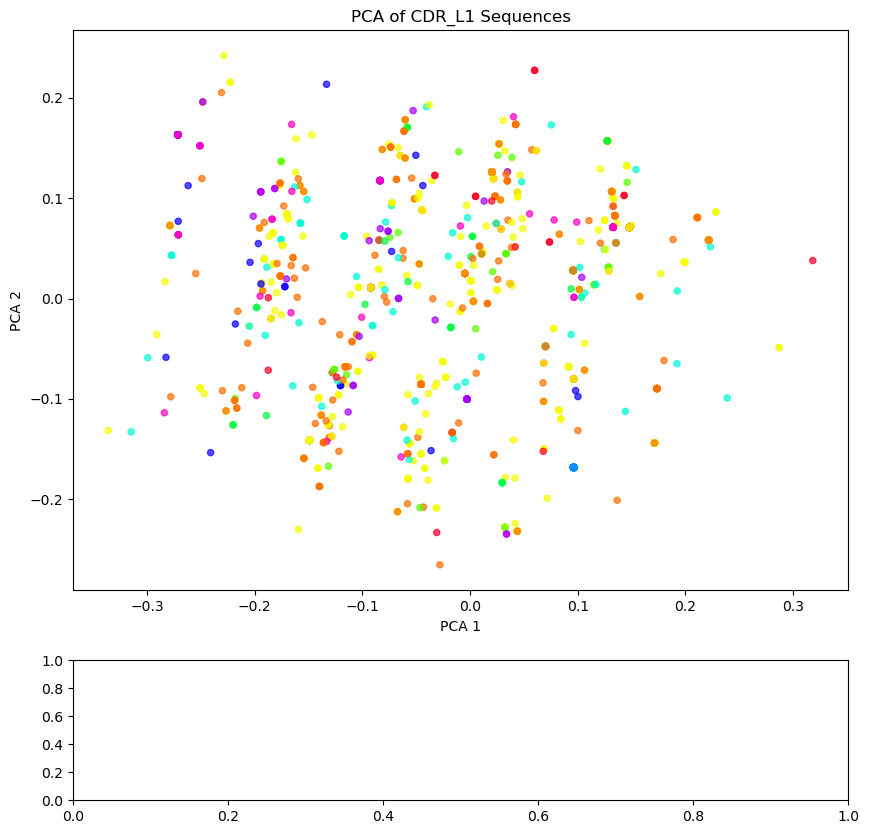

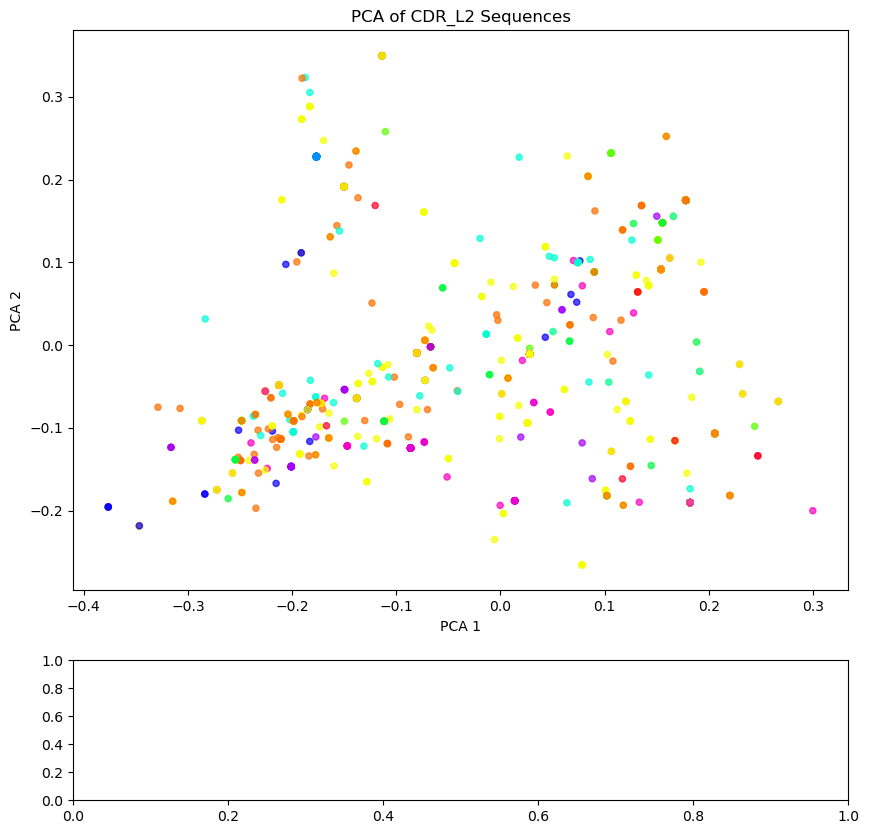

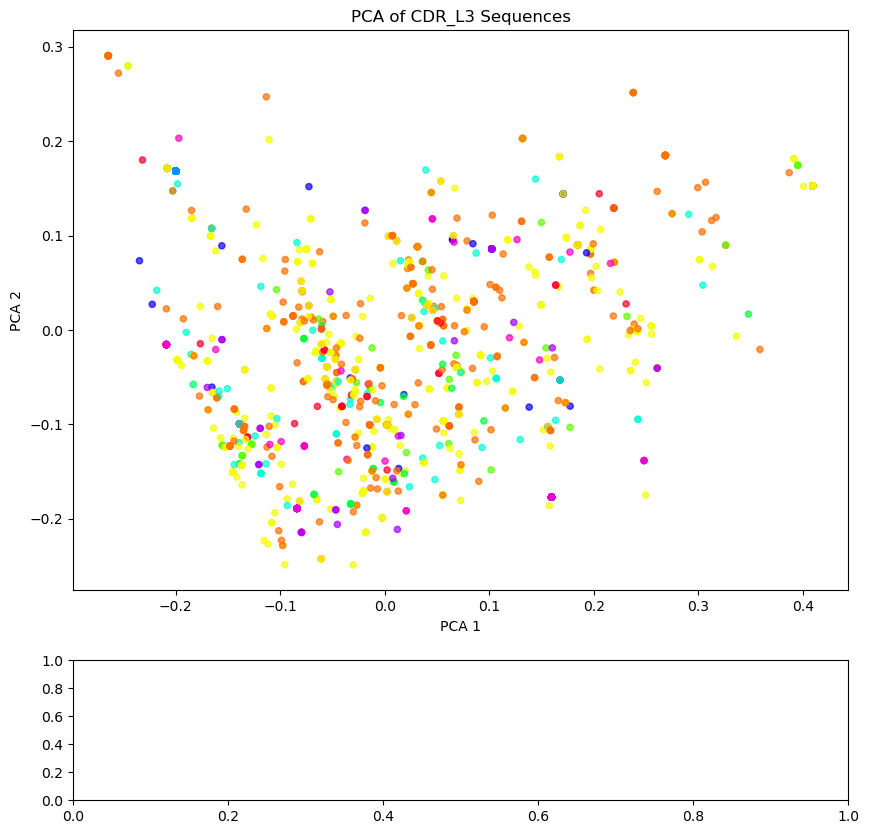

In [37]:
# nur die top 10 antigene damit übersichtlicher 

import ast
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

def residue_percentage(sequence, residues):
    """
    Berechnet den prozentualen Anteil jeder Aminosäure in der gegebenen Sequenz und gibt eine Liste seq_residues zurück,
    die jede Aminosäure als Tupel (residue, percentage) enthält.
    sequence: list, die eine CDR-Sequenz repäsentiert, und deren Einträge aus einem String pro Aminosäure besteht, z.B. ['A', 'R', 'N', ...]
    residues: list, die alle proteinogenen Aminosäuren genau einmal als String enthält
    """
    seq_residues = []
    for residue in residues:
        percentage = sequence.count(residue) / len(sequence)
        seq_residues.append((residue, percentage))
    return seq_residues

ab_ag_annotated = pd.read_csv('../data/ab_ag_annotated.tsv', sep='\t')
ab_ag_annotated.drop_duplicates(subset=['pdb','CDR_H1','CDR_H2','CDR_H3', 'CDR_L1', 'CDR_L2', 'CDR_L3'], inplace=True) #Entferne identische Antikörper-Sequenzen mit gleichen PDB-IDs und CDR-Sequenzen
ab_ag_annotated.dropna(subset=['CDR_H1', 'CDR_H2', 'CDR_H3', 'CDR_L1', 'CDR_L2', 'CDR_L3'], inplace=True) #Entferne Einträge ohne CDR-Sequenzen


#####liste mit den top antigen_names erstellen
top_antigens = ab_ag_annotated['antigen_name'].value_counts().head(10).index.tolist()
#dataframe filtern sodass nur top 10 antigene drin bleiben
ab_ag_annotated_top = ab_ag_annotated[ab_ag_annotated['antigen_name'].isin(top_antigens)].copy()
#antigen labels definieren sodass nur top 10
antigen_labels = ab_ag_annotated_top["antigen_name"].tolist()

#überprüfung was die top 10 sind
print("Top 10 Antigene:")
for ant in top_antigens:
    print(f"-{ant}")

def show_feature_space(feature_space, CDR_region, antigen_labels):#zusätzliches Argument für color-coding: antigen
    """
    Visualisiert den Feature-Space der CDR-Sequenzen mittels PCA in 3D.
    feature_space: pd.DataFrame, der die PDB-IDs in einer Spalte "pdb" und die prozentualen Anteile der Aminosäuren in den entsprechenden CDR-Sequenzen
    in je einer Spalte pro Aminosäure enthält.
    """
    X = feature_space.drop(columns=["pdb"])
    coords = PCA(n_components=2).fit_transform(X)
    #hier nochmal die top 10 damit unique antigens auch wirklich nur die top 10 nimmt 
    #####liste mit den top antigen_names erstellen
    top_antigens = ab_ag_annotated['antigen_name'].value_counts().head(10).index.tolist()
    #dataframe filtern sodass nur top 10 antigene drin bleiben
    ab_ag_annotated_top = ab_ag_annotated[ab_ag_annotated['antigen_name'].isin(top_antigens)].copy()
    #antigen labels definieren sodass nur top 10
    antigen_labels = ab_ag_annotated_top["antigen_name"].tolist()

    #### Farbzuordnung vorbereiten
    import matplotlib.lines as mlines

    unique_antigens = sorted(list(set(antigen_labels)))
    color_map = plt.get_cmap('gist_rainbow_r', len(unique_antigens))
    color_dict = {antigen: color_map(i) for i, antigen in enumerate(unique_antigens)}
    colors = [color_dict[a] for a in antigen_labels]
   

    # Plotten der PCA-Koordinaten in 3D
    fig, (ax_scatter, ax_legend) = plt.subplots(2,1,figsize=(10,10), gridspec_kw={'height_ratios': [4,1]})
    ax_scatter.scatter(coords[:, 0], coords[:, 1], c=colors, s=20, alpha=0.7)#zusätzliche Argumente für color-coding: c=color_codes, cmap='tab20', 
    ax_scatter.set_xlabel("PCA 1")
    ax_scatter.set_ylabel("PCA 2")
    ax_scatter.set_title(f"PCA of {CDR_region} Sequences")


    # 2. Legende als eigene Figure
legend_fig, legend_ax = plt.subplots(figsize=(12, 12))  # Größe anpassen je nach Anzahl Antigene
legend_ax.axis('off')  # Keine Achsen

# Erstelle Handles
handles = [mlines.Line2D([], [], color=color_dict[ant], marker='o', linestyle='None',
                         markersize=8, label=ant)
           for ant in unique_antigens]

# Erzeuge Legende
legend = legend_ax.legend(handles=handles, loc='center', ncol=1, fontsize='small')  # ncol=1 → alle untereinander

legend_fig.tight_layout()
plt.show()

# Bereite ab_ag_annotated vor
ab_ag_annotated = pd.read_csv('../data/ab_ag_annotated.tsv', sep='\t')
ab_ag_annotated.drop_duplicates(subset=['pdb','CDR_H1','CDR_H2','CDR_H3', 'CDR_L1', 'CDR_L2', 'CDR_L3'], inplace=True) #Entferne identische Antikörper-Sequenzen mit gleichen PDB-IDs und CDR-Sequenzen
ab_ag_annotated.dropna(subset=['CDR_H1', 'CDR_H2', 'CDR_H3', 'CDR_L1', 'CDR_L2', 'CDR_L3'], inplace=True) #Entferne Einträge ohne CDR-Sequenzen

####sonst kann man nicht drauf zugreifen
import matplotlib.lines as mlines

unique_antigens = sorted(list(set(antigen_labels)))
color_map = plt.get_cmap('gist_rainbow_r', len(unique_antigens))
color_dict = {antigen: color_map(i) for i, antigen in enumerate(unique_antigens)}
colors = [color_dict[a] for a in antigen_labels]

# Schleife über die CDR-Regionen, um den Feature-Space für jede CDR-Sequenz zu erstellen und zu visualisieren:
for CDR_region in ["CDR_H1", "CDR_H2", "CDR_H3", "CDR_L1", "CDR_L2", "CDR_L3"]:
    # pd.dataframe mit den PDB-IDs und CDR-Sequenzen erstellen. Einträge sind keine Listen, sondern Strings, die Listen repräsentieren (aufgrund der .to_csv()-Methode)!
    sequences = ab_ag_annotated_top[["pdb", CDR_region]].copy()
    # CDR-Sequenzen im pd.dataframe sequences von Strings in Listen umwandeln. Die .items() greift auf die Index-Eintrag-Paare des pd.dataframes sequences zu.
    for i, s in sequences[CDR_region].items(): #i= Index, s = String, l= Liste
        l = ast.literal_eval(s)
        sequences.at[i, CDR_region] = l
    
    # Liste aller einzigartigen, proteinogenen Aminosäuren erstelllen, die in den CDR-Sequenzen vorkommen. Wird als Argument für residue_percentage benötigt.
    sequences_list = sequences[CDR_region].tolist()
    residues = sorted(np.unique(np.concatenate(sequences_list)))

    # Leere Matrix für den Feature-Space vorbereiten. Enthält die PDB-IDs, aber noch keine prozentualen Anteile der Aminosäuren.
    feature_space = pd.DataFrame(columns=residues, index=sequences.index)
    feature_space.insert(0, "pdb", ab_ag_annotated_top["pdb"])
    
    # Berechne den prozentualen Anteil jeder Aminosäure in den CDR-Sequenzen und füge sie in den Feature-Space ein.
    rows = [] #um daten vor befüllen des dataframes vorzubereiten damit es nicht so lange dauert
    for i in feature_space.index:
        sequence = sequences.at[i, CDR_region]
        seq_residues = residue_percentage(sequence, residues)
        row = {'pdb': sequences.at[i,'pdb']} #auch für schneller
        for residue, percentage in seq_residues: # Für jedes Tupel (Residue, prozentualer Anteil) in der Liste seq_residues
            feature_space.at[i, residue] = percentage # Füge den prozentualen Anteil des Residues in der CDR-Sequenz in die entsprechende Spalte ein
        rows.append(row)
    show_feature_space(feature_space, CDR_region, antigen_labels)



#Überprüfung ob alle punkte mit gleichem antigen-name die gleiche farbe haben am bsp influenza a virus
idx_influenzaavirus = [i for i, a in enumerate(antigen_labels) if a == "influenza a virus"]
set([colors[i] for i in idx_influenzaavirus])

#alle fraben pro antigen tabellarisch
for ant in set(antigen_labels):
    print(f"{ant}: {color_dict[ant]}")